### Analyzing health data from Samsung's devices over a span of 6 years to study sleep patterns

In [44]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
samsung_base_dir = os.path.join('..', 'input', 'samsung')

In [45]:
#We start with reading the Samsung's Dataset and getting a glipmse of it

sleep=pd.read_csv("sleep.csv")
sleep.head(5)

,date,has_sleep_data,efficiency,sleep_score,sleep_duration,start_time,start_time_epoch,update_time,update_time_epoch,create_time,create_time_epoch,time_offset,end_time,end_time_epoch,total_sleep
0,8/4/2018,1,88.42315,NaN,NaN,8/4/2018 19:43,1533411780,8/5/2018 4:18,1533442684,8/5/2018 4:18,1533442684,UTC+0300,8/5/2018 4:03,1533441780,8:20:00
1,8/5/2018,1,90.50279,NaN,NaN,8/5/2018 20:31,1533501060,8/5/2018 23:43,1533512622,8/5/2018 23:43,1533512622,UTC+0300,8/5/2018 23:29,1533511740,2:58:00
2,8/6/2018,1,78.46154,NaN,NaN,8/6/2018 12:26,1533558360,8/6/2018 13:44,1533563071,8/6/2018 13:44,1533563071,UTC+0300,8/6/2018 13:30,1533562200,1:04:00
3,8/6/2018,1,93.52518,NaN,NaN,8/6/2018 21:31,1533591060,8/7/2018 2:22,1533608566,8/7/2018 2:22,1533608566,UTC+0300,8/7/2018 2:08,1533607680,4:37:00
4,8/7/2018,1,86.59004,NaN,NaN,8/7/2018 19:28,1533670080,8/8/2018 0:02,1533686555,8/8/2018 0:02,1533686555,UTC+0300,8/7/2018 23:48,1533685680,4:20:00


In [61]:
#Understanding it Data types
sleep.dtypes

date                    datetime64[ns]
has_sleep_data                   int64
efficiency                     float64
sleep_score                    float64
sleep_duration                 float64
start_time                      object
start_time_epoch                 int64
update_time                     object
update_time_epoch                int64
create_time                     object
create_time_epoch                int64
time_offset                     object
end_time                        object
end_time_epoch                   int64
total_sleep            timedelta64[ns]
hours                            int32
minutes                          int32
Month                        period[M]
total_sleep_minutes              int32
Day                          period[D]
dtype: object

In [65]:
#Counting number entries for sleep data

print(f"Total number of entries in the dataset: {sleep['date'].count()}")

Total number of entries in the dataset: 1829


In [46]:
#Convert 'date' from string to Datetime format
sleep['date'] = pd.to_datetime(sleep['date'], format='%m/%d/%Y')

In [47]:
#Convert 'total_sleep' from string to time format
sleep['total_sleep'] = pd.to_timedelta(sleep['total_sleep'])

In [48]:
# Ensuring 'total_sleep' column is in timedelta format
sleep['hours'] = sleep['total_sleep'].dt.components['hours'].astype(int)
sleep['minutes'] = sleep['total_sleep'].dt.components['minutes'].astype(int)


In [49]:
# Ensure 'hours' and 'minutes' are in integer format
sleep['hours'] = sleep['hours'].astype(int)
sleep['minutes'] = sleep['minutes'].astype(int)

### Our first plot is to find average sleep per month. To do this, we need to group the data by month to combine data of multiple years into one.

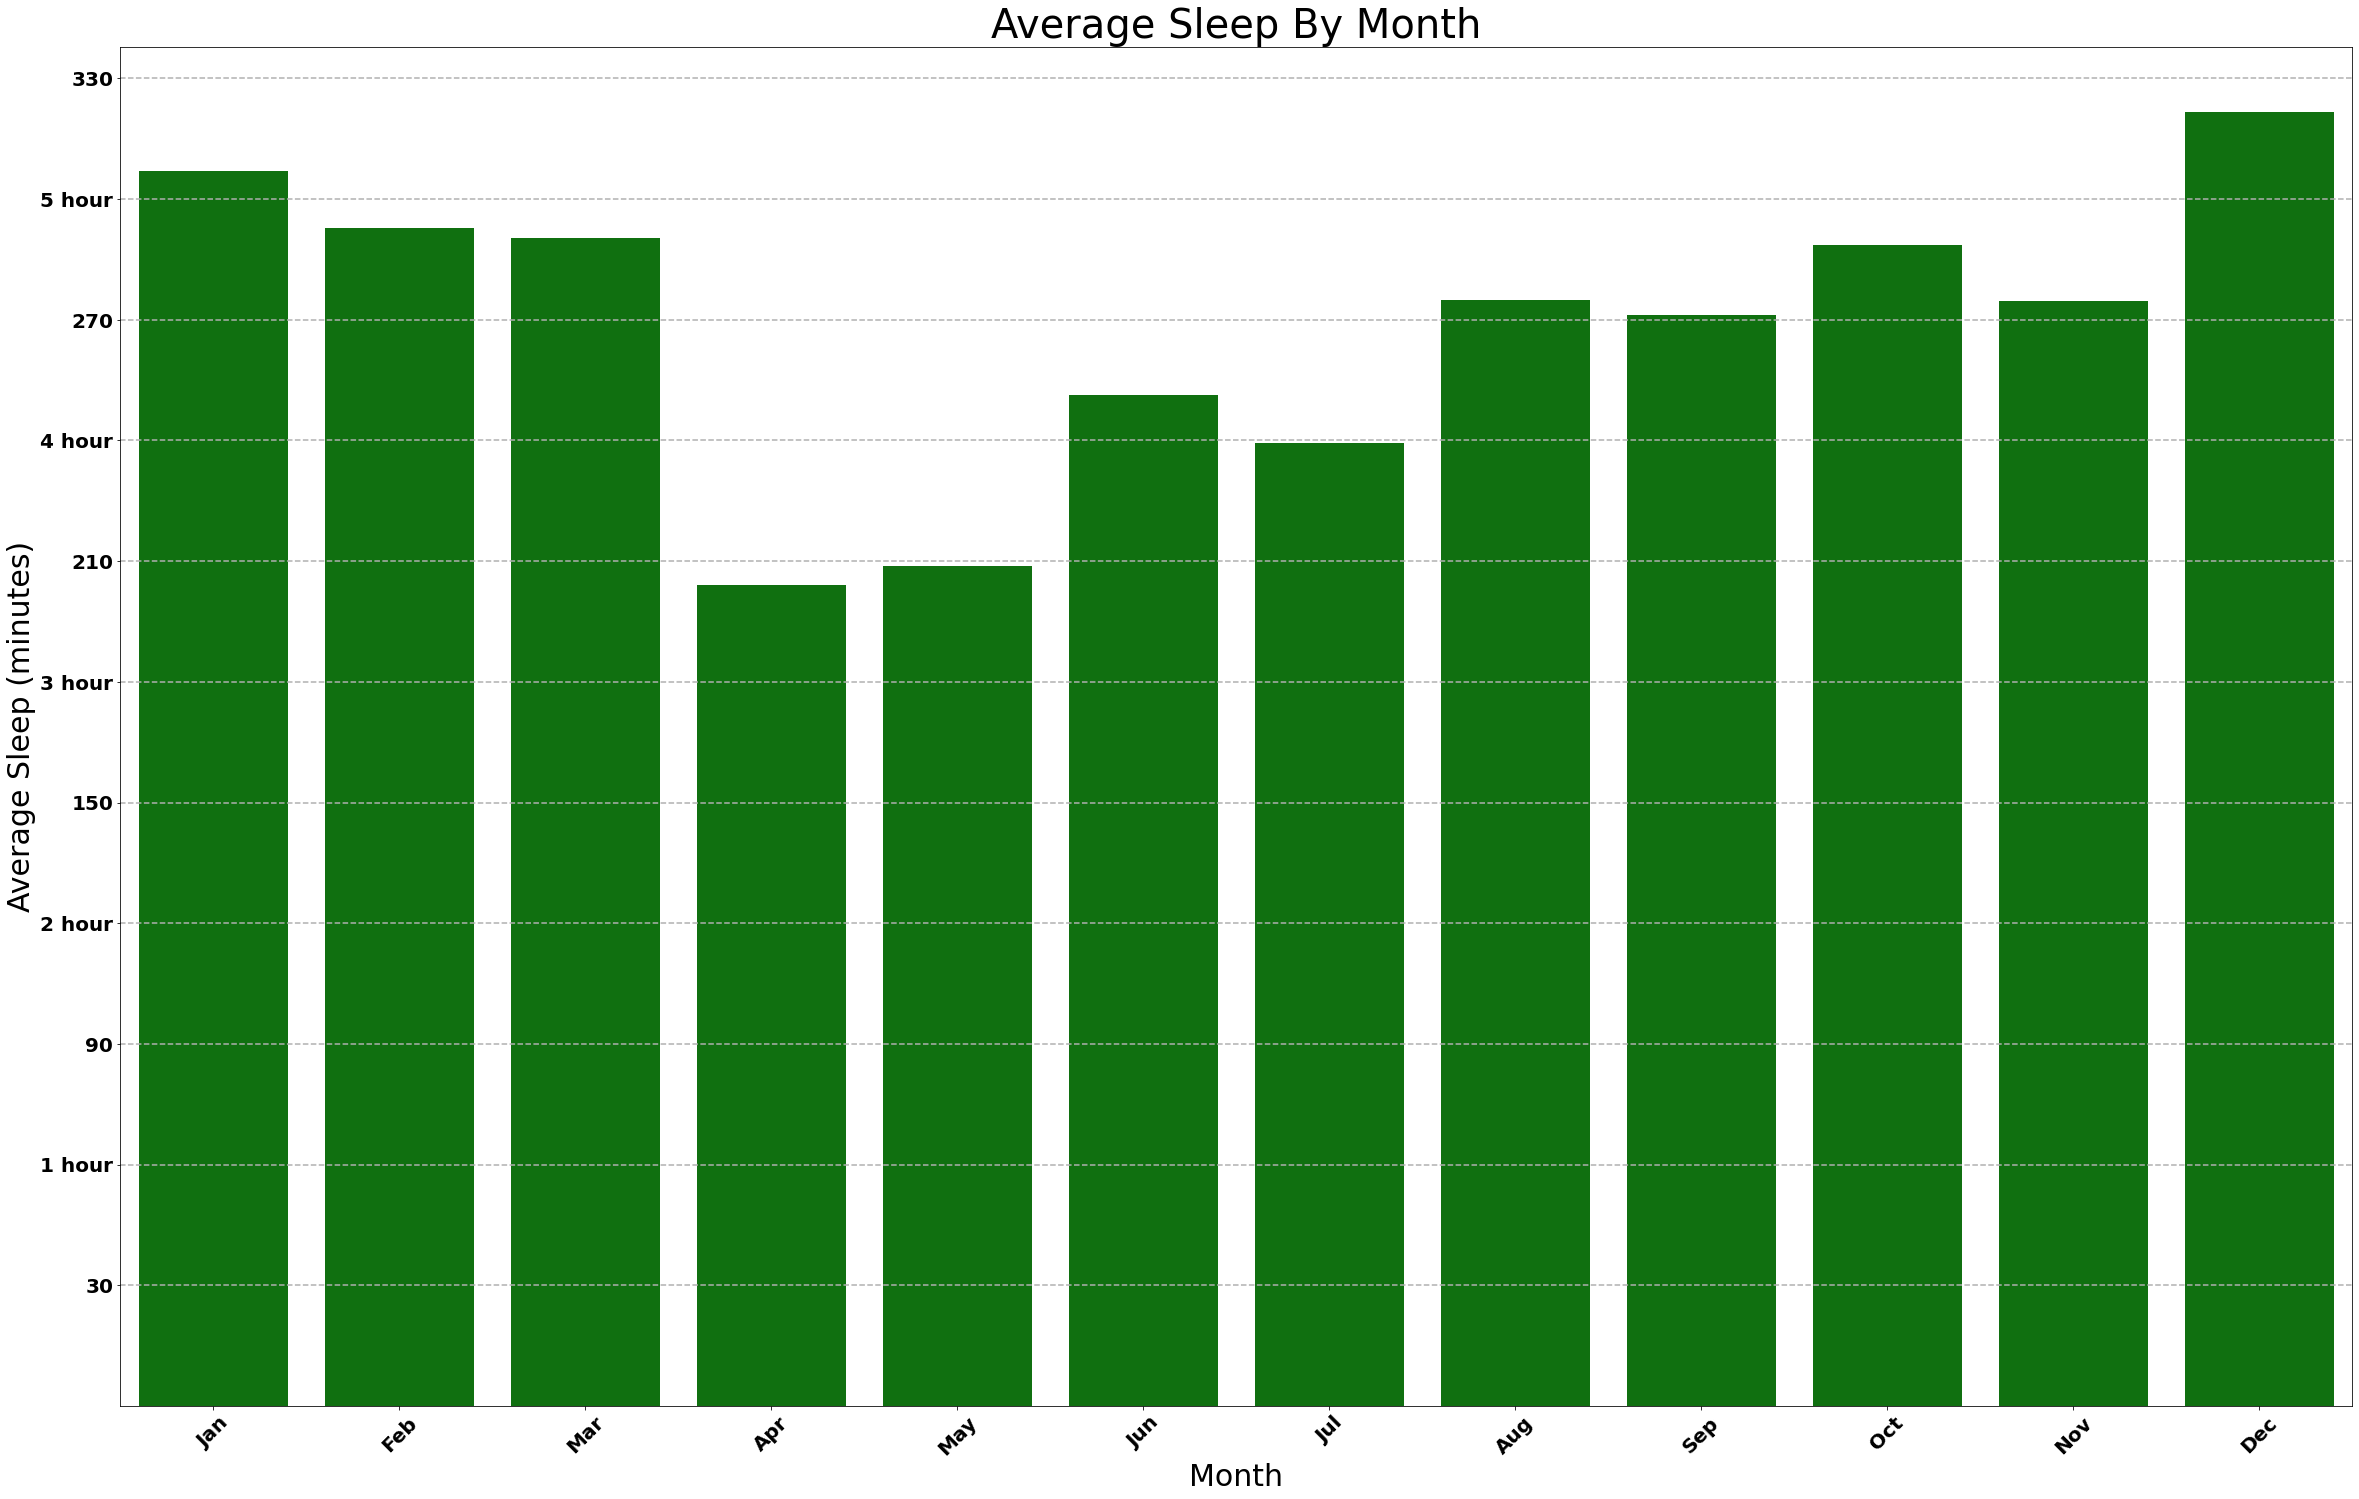

In [116]:
# With 'date' column in datetime format
sleep['Month'] = sleep['date'].dt.to_period('M')

# Calculate total sleep time in minutes
sleep['total_sleep_minutes'] = sleep['hours'] * 60 + sleep['minutes']

# Calculate average sleep per month
average_sleep_per_month = sleep.groupby('Month')['total_sleep_minutes'].mean().reset_index()

# Grouping by month across all years
monthly_average_sleep = average_sleep_per_month.groupby(average_sleep_per_month['Month'].dt.month)['total_sleep_minutes'].mean().reset_index()

# Define a custom colormap ranging from light grey to black based on average sleep duration
min_avg = monthly_average_sleep['total_sleep_minutes'].min()
max_avg = monthly_average_sleep['total_sleep_minutes'].max()

cmap = mcolors.LinearSegmentedColormap.from_list("CustomMap", [(0, 'lightgrey'), (1, 'black')])

# Normalize average sleep durations to range between 0 and 1 for colormap usage
normalized = (monthly_average_sleep['total_sleep_minutes'] - min_avg) / (max_avg - min_avg)

# Plotting with Seaborn using the custom colormap
plt.figure(figsize=(40, 25))  # Maintain the larger figure size
ax = sns.barplot(x='Month', y='total_sleep_minutes', data=monthly_average_sleep, color='green')

# Rotate x-labels for better readability
plt.xticks(rotation=45)

# Adjust font sizes for better readability
plt.title('Average Sleep By Month', fontsize=40)
plt.xlabel('Month', fontsize=30)
plt.ylabel('Average Sleep (minutes)', fontsize=30)

# Change month numbers to month names in x-axis labels
ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)], fontsize=20, fontweight='bold')

# Set y-axis ticks starting from 30 minutes with bold font, skipping 0 hour
ticks = range(30, int(monthly_average_sleep['total_sleep_minutes'].max()) + 30, 30)
tick_labels = [f'{i // 60} hour' if i % 60 == 0 else i for i in ticks]
plt.yticks(ticks, tick_labels, fontsize=20, fontweight='bold')

# Customize grid lines (dashed lines)
plt.grid(axis='y', linestyle='--', linewidth=1.5)

# Save the plot as an image
#plt.savefig('average_sleep_per_month_large_green.png', dpi=300)  # Maintain the higher DPI

# Show the plot
plt.show()


### Now we add horizontal line to the plot that would display the mean sleep throughout the recorded data, to compare it witth with each month

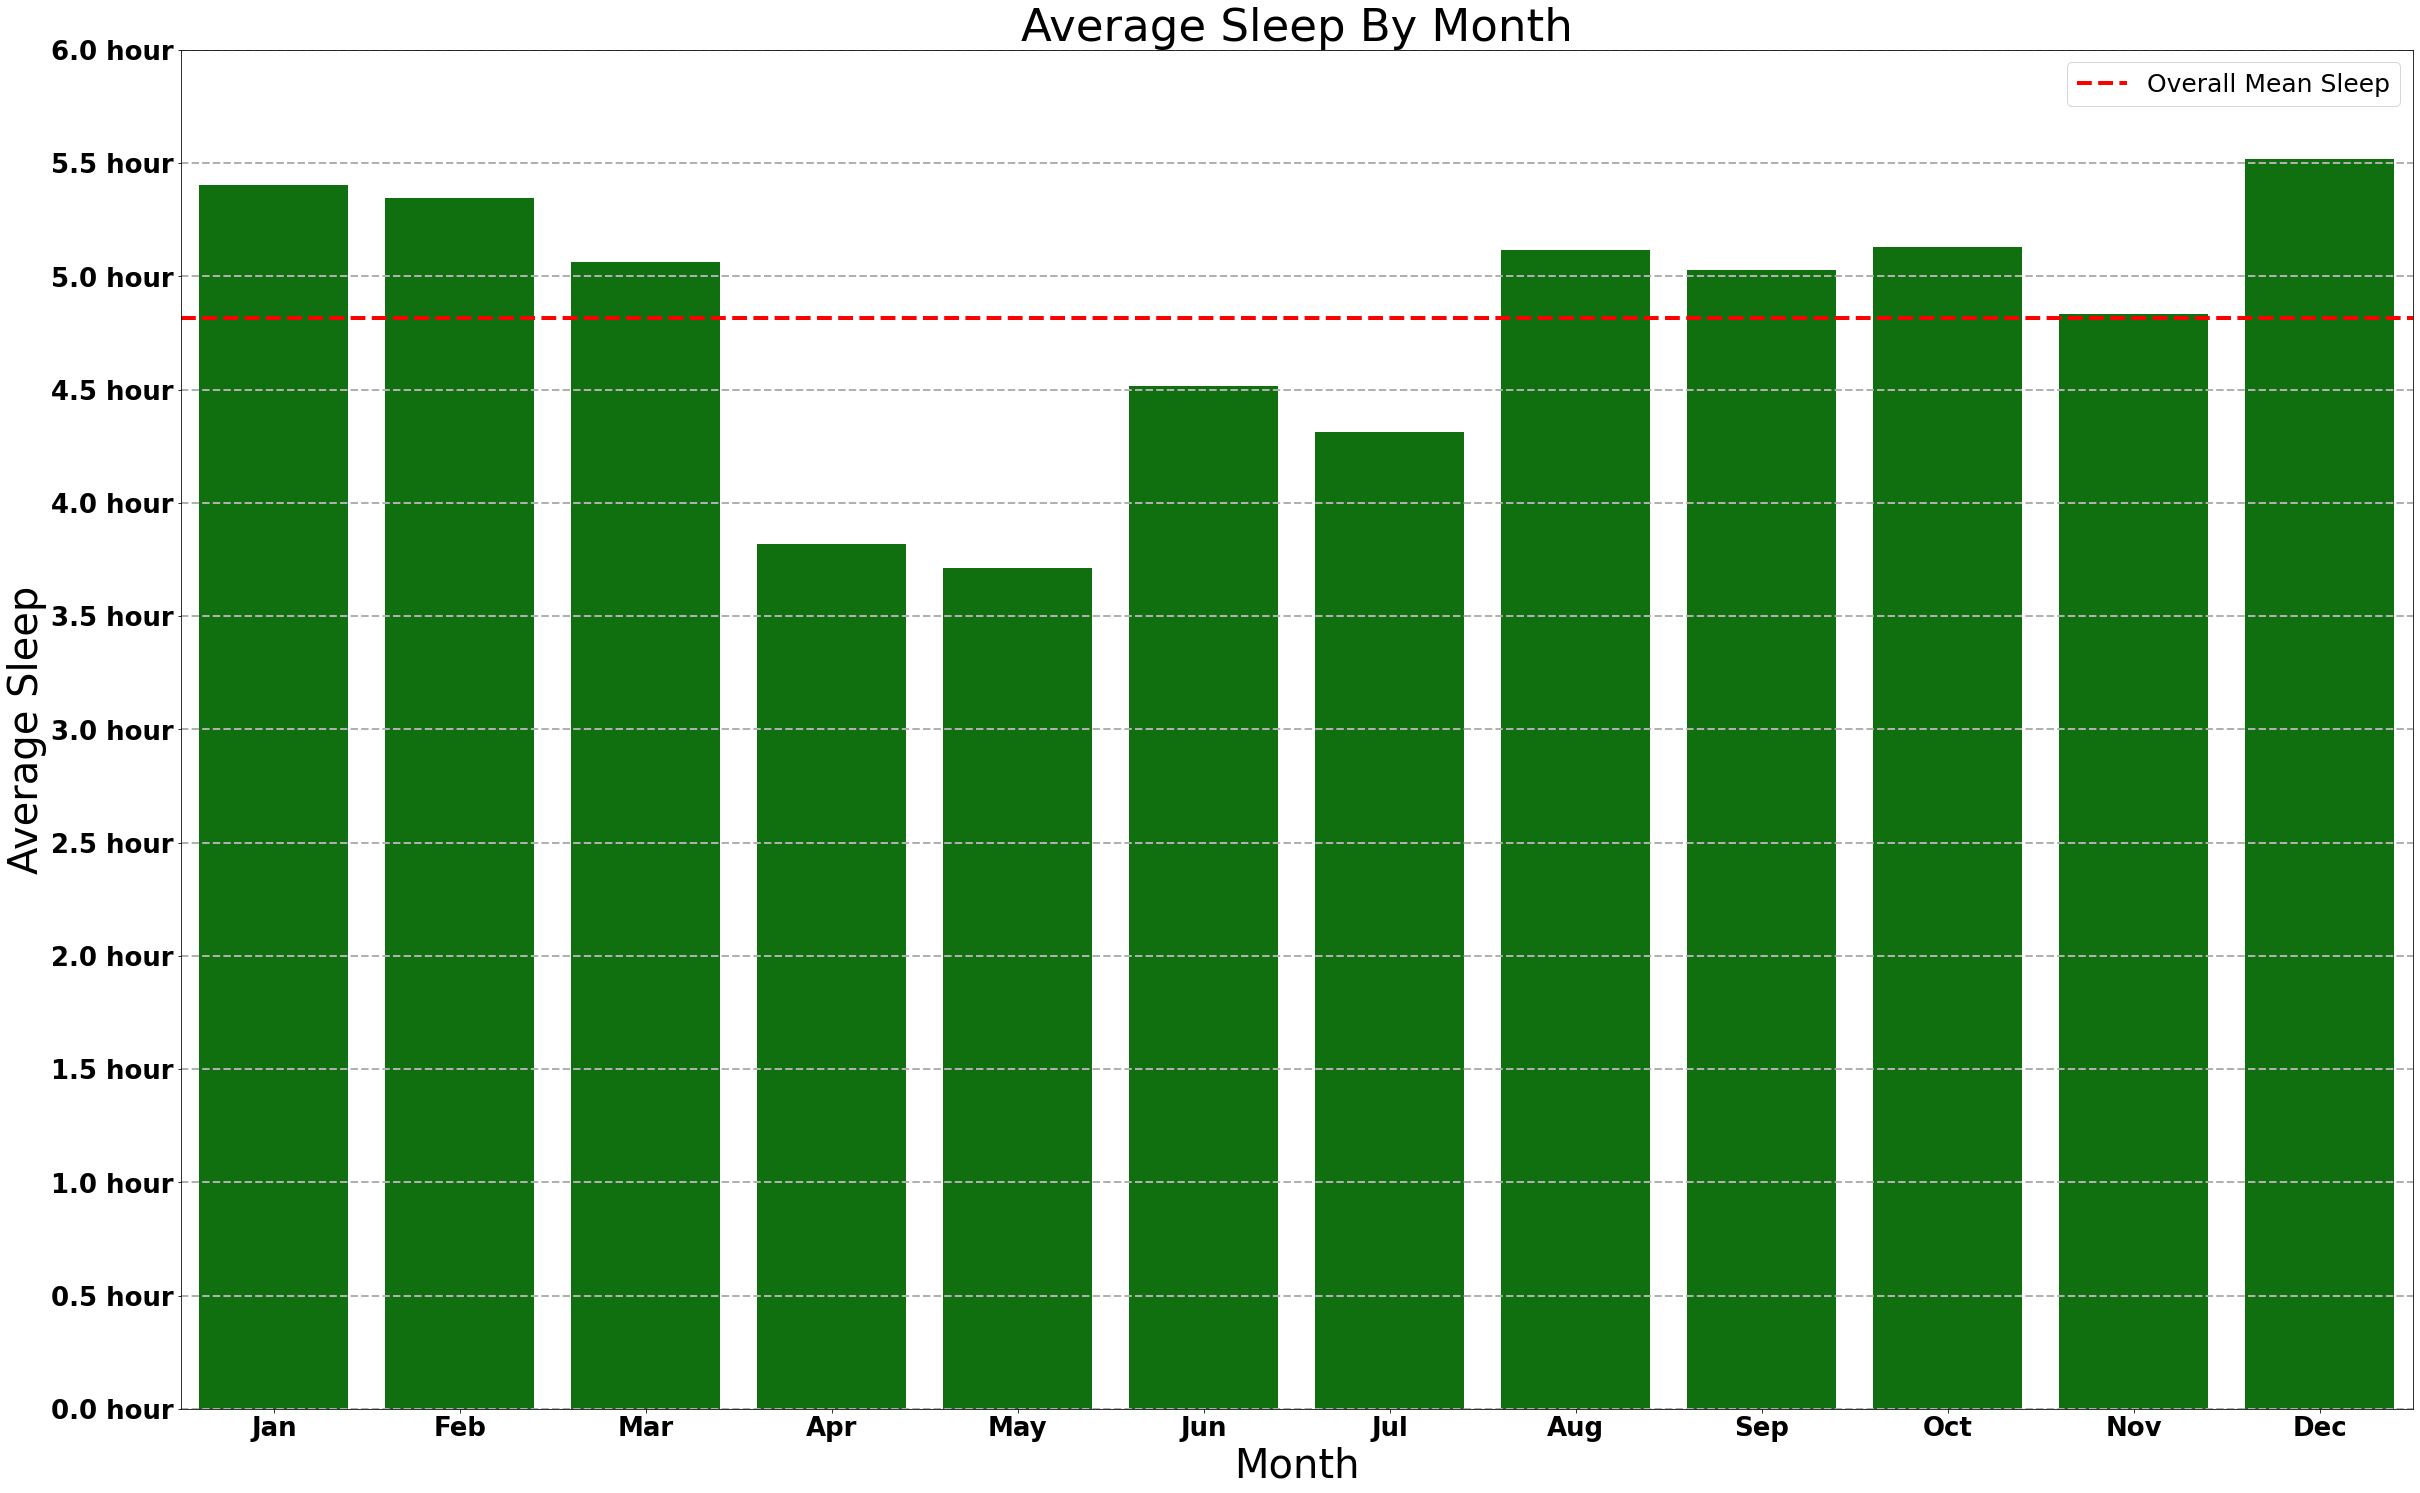

In [115]:

sleep['Day'] = sleep['date'].dt.to_period('D')  # Group by day

# Calculate total sleep time in minutes
sleep['total_sleep_minutes'] = sleep['hours'] * 60 + sleep['minutes']

# Calculate average sleep per day
average_sleep_per_day = sleep.groupby('Day')['total_sleep_minutes'].mean().reset_index()

# Convert 'Day' column to datetime
average_sleep_per_day['Day'] = average_sleep_per_day['Day'].dt.to_timestamp()

# Group by month and calculate average sleep per month
average_sleep_per_month = average_sleep_per_day.groupby(average_sleep_per_day['Day'].dt.to_period('M'))['total_sleep_minutes'].mean().reset_index()

# Convert total sleep time to hours for the y-axis
average_sleep_per_month['total_sleep_hours'] = average_sleep_per_month['total_sleep_minutes'] / 60

# Group by month (ignoring years) and calculate overall mean sleep
monthly_overall_mean_sleep = average_sleep_per_month.groupby(average_sleep_per_month['Day'].dt.month)['total_sleep_hours'].mean().reset_index()

# Plotting with Seaborn
plt.figure(figsize=(40, 25))  # Increase figure size
ax = sns.barplot(x='Day', y='total_sleep_hours', data=monthly_overall_mean_sleep, color='green')

# Adjust font sizes for better readability
plt.title('Average Sleep By Month', fontsize=45)
plt.xlabel('Month', fontsize=40)
plt.ylabel('Average Sleep', fontsize=40)

# Change month numbers to month names in x-axis labels
ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)], fontsize=26, fontweight='bold')

# Set y-axis ticks starting from 0.5 hours with bold font
ticks = [i / 2 for i in range(int(monthly_overall_mean_sleep['total_sleep_hours'].max()) * 2 + 3)]  # Extend by 2 units
tick_labels = [f'{i:.1f} hour' for i in ticks]
plt.yticks(ticks, tick_labels, fontsize=26, fontweight='bold')

# Add a horizontal line for the overall mean sleep
plt.axhline(y=monthly_overall_mean_sleep['total_sleep_hours'].mean(), color='red', linestyle='--', linewidth=4, label='Overall Mean Sleep')

# Customize grid lines (dashed lines)
plt.grid(axis='y', linestyle='--', linewidth=2)

# Add a legend
plt.legend(fontsize=25)

# Save the plot as an image
# plt.savefig('average_sleep_each_month_large_green_agg.png', dpi=300)  # Increase DPI for a sharper image

# Show the plot
plt.show()


### Plotting average sleep each month. To do this, we ungroup the data by month, performed earlier which would display the average of each month from Aug-18 - Mar-23

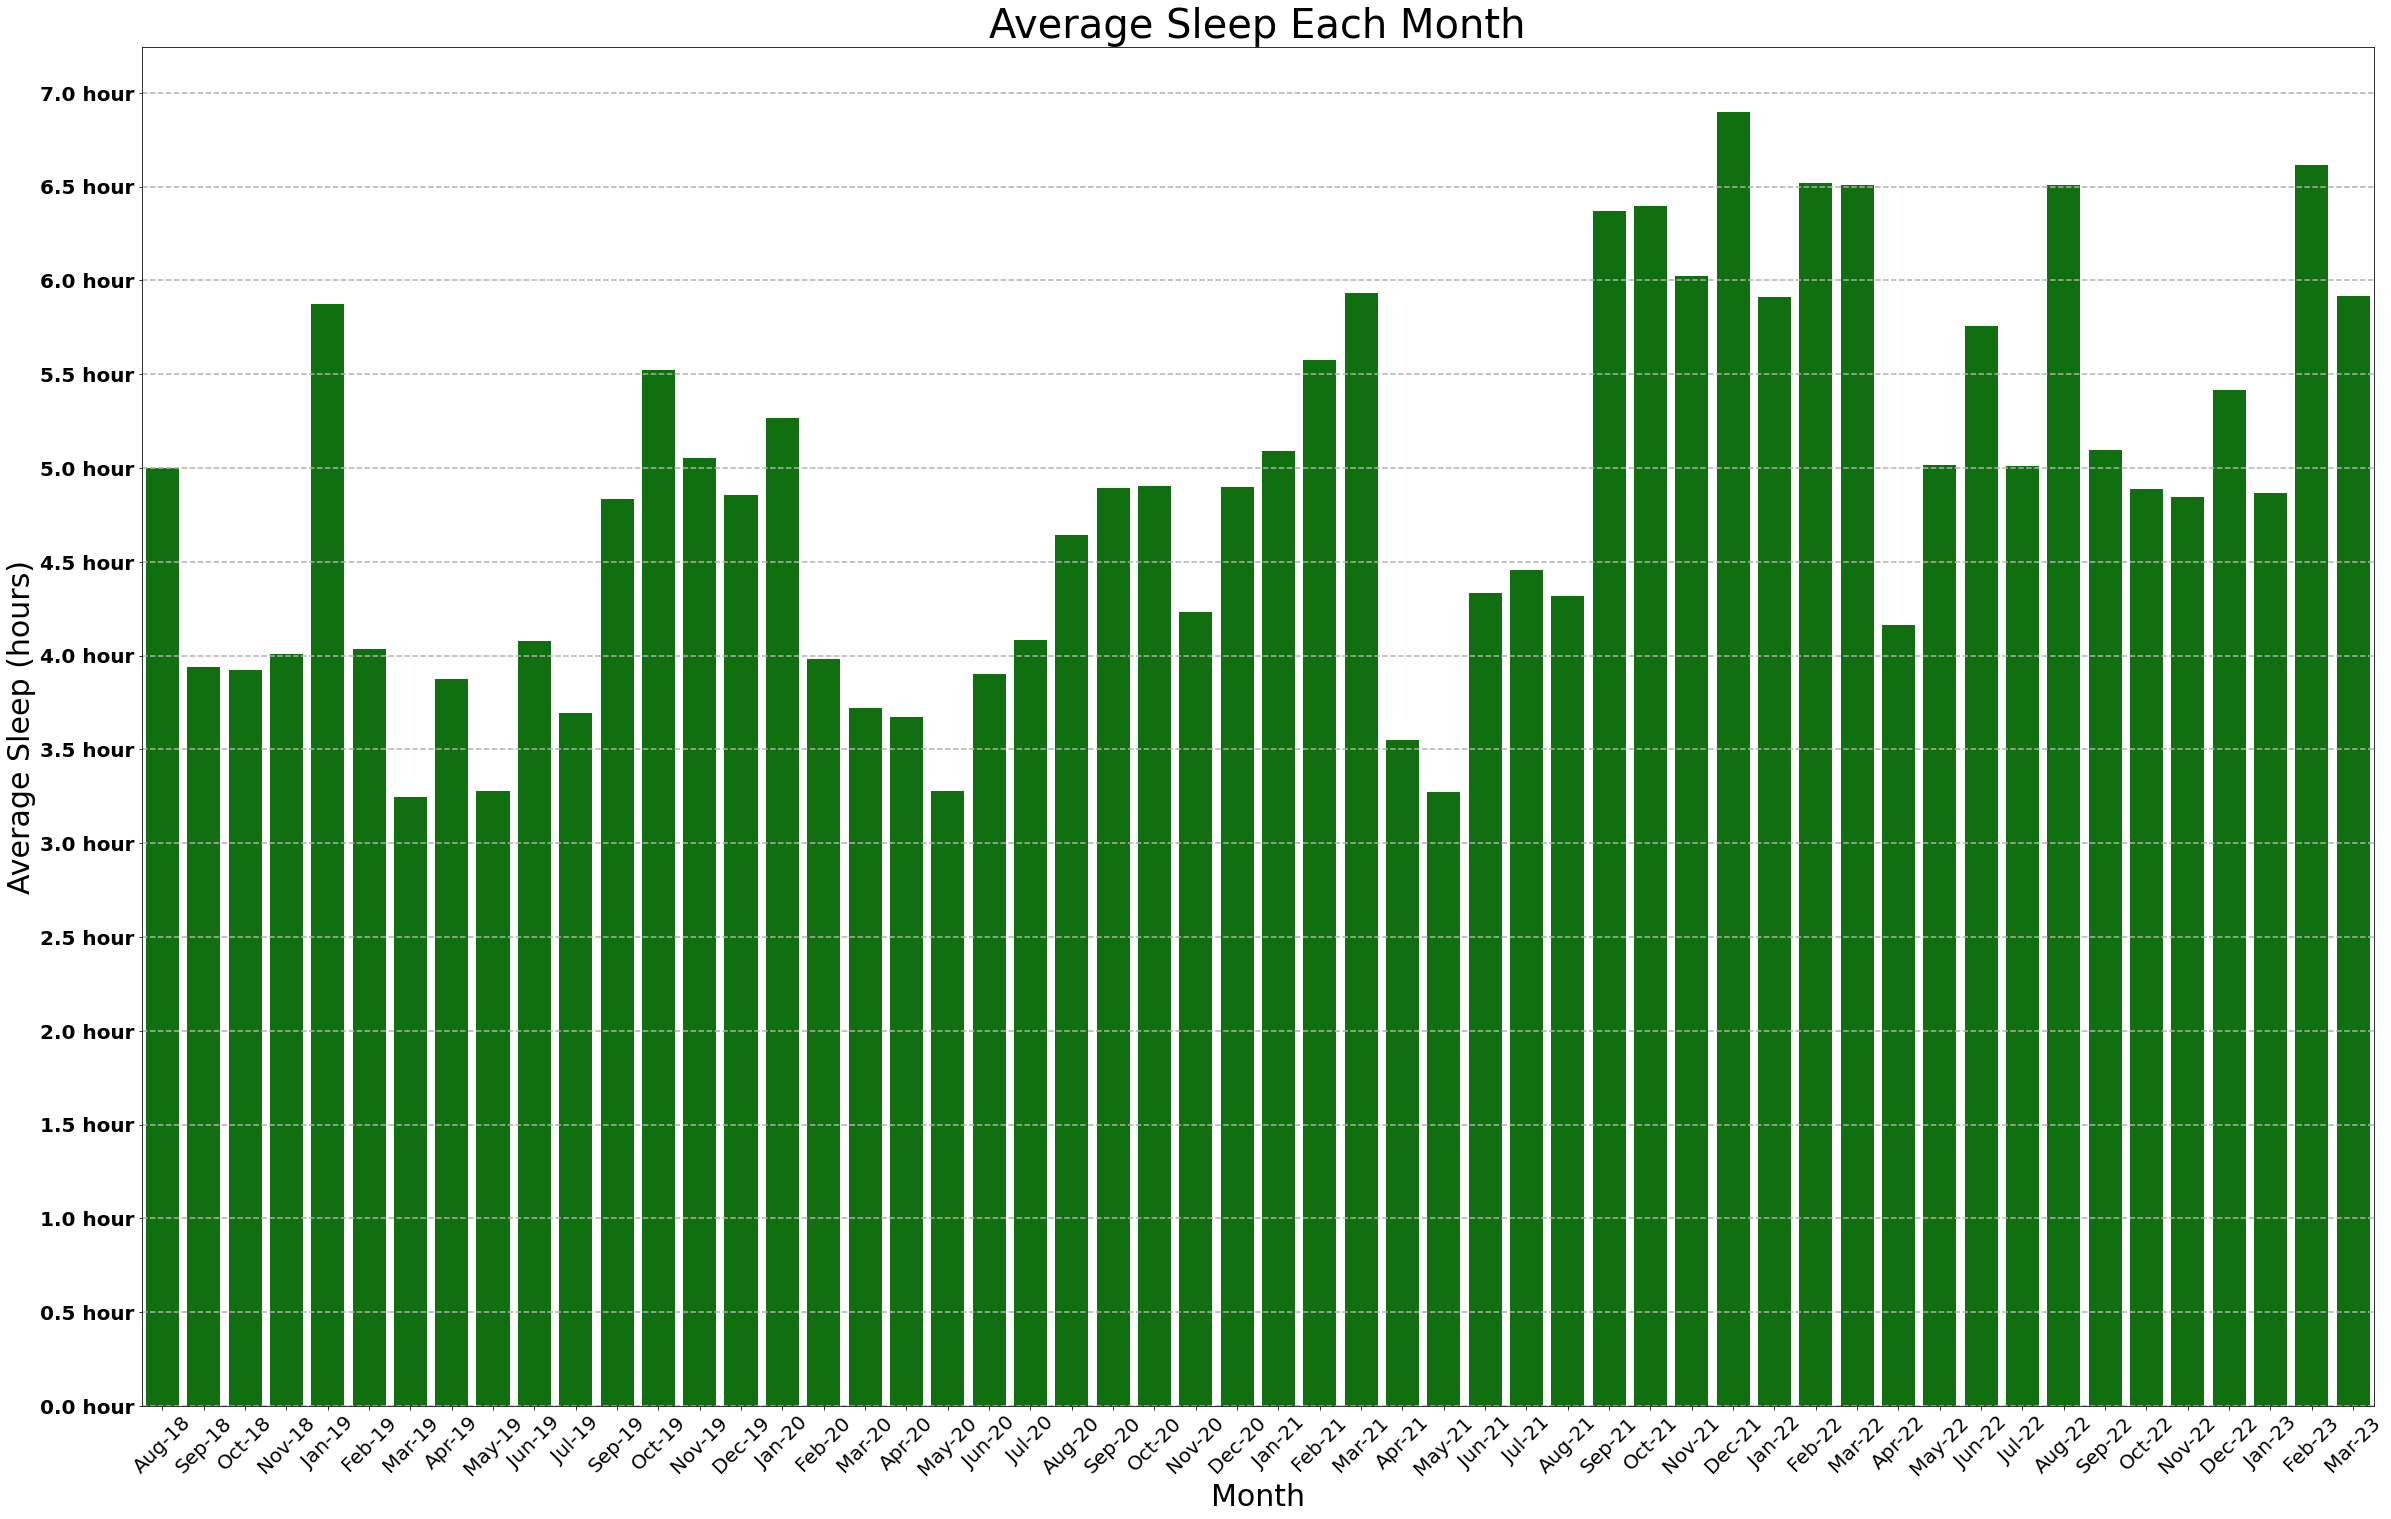

In [118]:

sleep['Day'] = sleep['date'].dt.to_period('D')  # Group by day

# Calculate total sleep time in minutes
sleep['total_sleep_minutes'] = sleep['hours'] * 60 + sleep['minutes']

# Calculate average sleep per day
average_sleep_per_day = sleep.groupby('Day')['total_sleep_minutes'].mean().reset_index()

# Convert 'Day' column to datetime
average_sleep_per_day['Day'] = average_sleep_per_day['Day'].dt.to_timestamp()

# Group by month and calculate average sleep per month
average_sleep_per_month = average_sleep_per_day.groupby(average_sleep_per_day['Day'].dt.to_period('M'))['total_sleep_minutes'].mean().reset_index()

# Convert total sleep time to hours for the y-axis
average_sleep_per_month['total_sleep_hours'] = average_sleep_per_month['total_sleep_minutes'] / 60

# Plotting with Seaborn
plt.figure(figsize=(40, 25))  # Increase figure size
ax = sns.barplot(x='Day', y='total_sleep_hours', data=average_sleep_per_month, color='green')

# Rotate x-labels for better readability
plt.xticks(rotation=45)

# Adjust font sizes for better readability
plt.title('Average Sleep Each Month', fontsize=40)
plt.xlabel('Month', fontsize=30)
plt.ylabel('Average Sleep (hours)', fontsize=30)

# Set y-axis ticks starting from 0.5 hours with bold font
ticks = [i / 2 for i in range(int(average_sleep_per_month['total_sleep_hours'].max()) * 2 + 3)]
tick_labels = [f'{i:.1f} hour' for i in ticks]
plt.yticks(ticks, tick_labels, fontsize=20, fontweight='bold')

# Customize grid lines (dashed lines)
plt.grid(axis='y', linestyle='--', linewidth=1.5)

# Format x-axis labels to mmm-yy
ax.set_xticklabels(average_sleep_per_month['Day'].dt.strftime('%b-%y'), fontsize=20)

# Save the plot as an image
#plt.savefig('average_sleep_each_month_large_green_agg.png', dpi=300)  # Increase DPI for a sharper image

# Show the plot
plt.show()


### Adding a similar horizontal line to the plot that would display the mean sleep throughout the recorded data

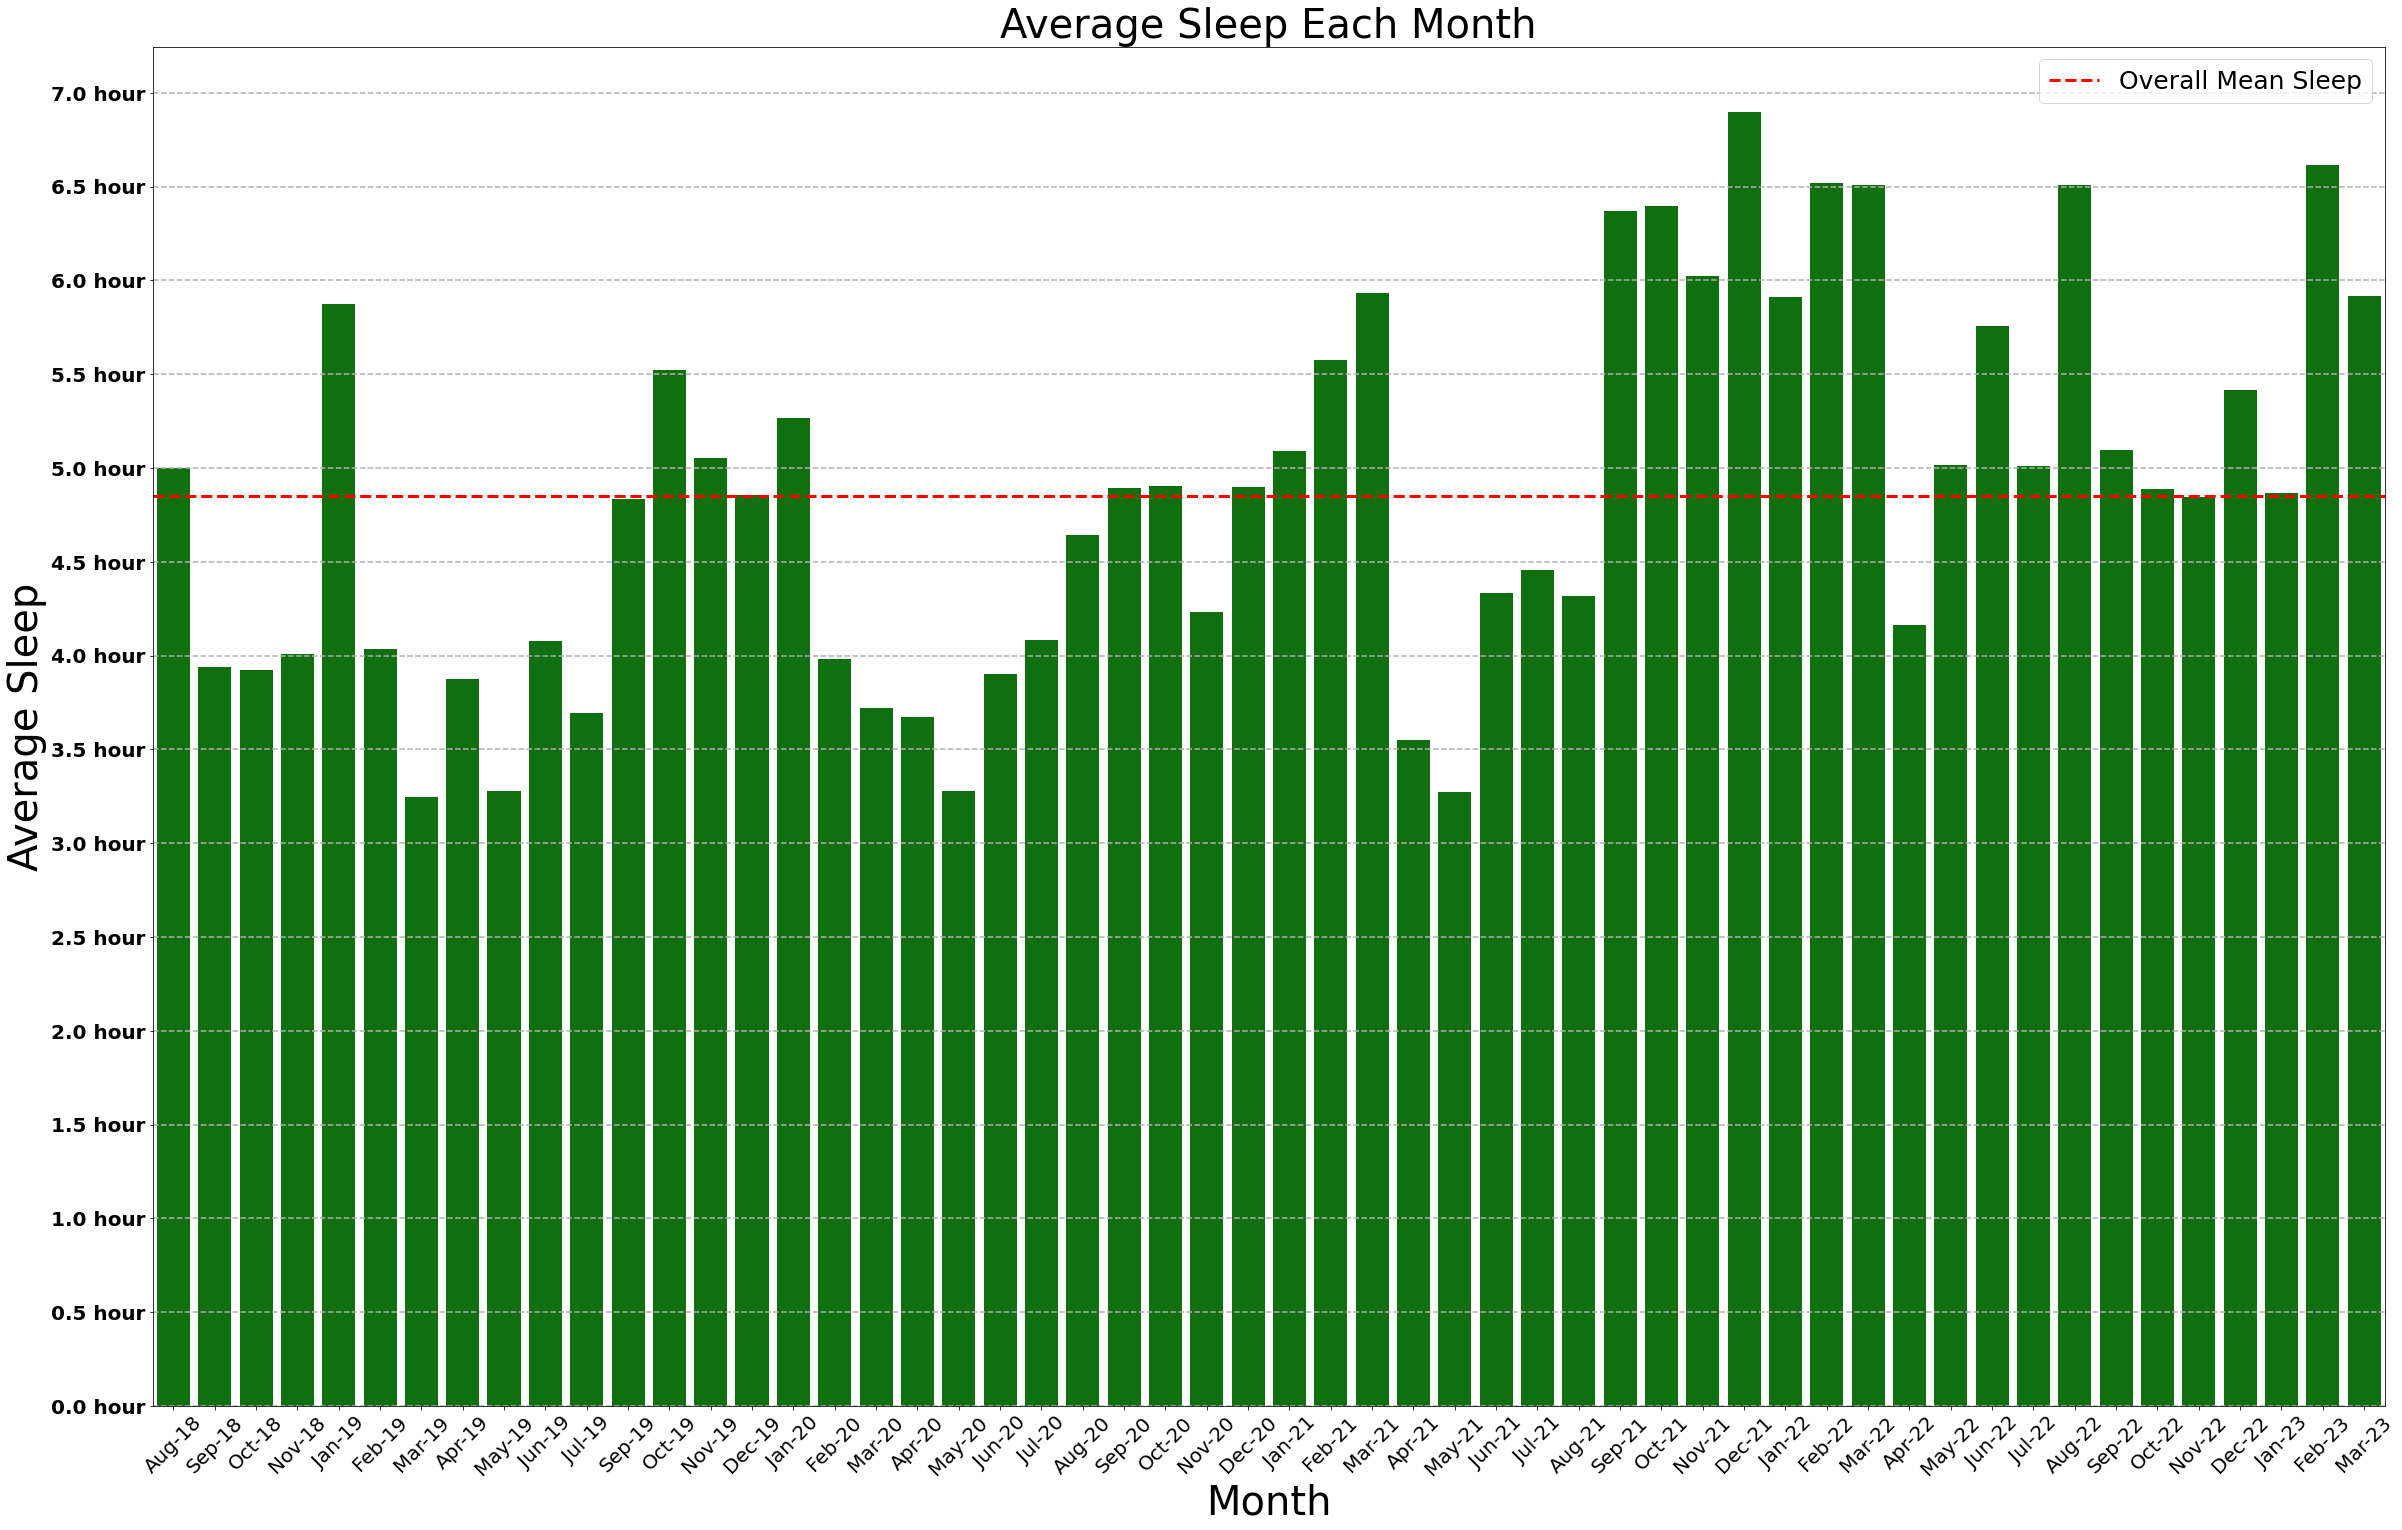

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'date' column is in datetime format
sleep['Day'] = sleep['date'].dt.to_period('D')  # Group by day

# Calculate total sleep time in minutes
sleep['total_sleep_minutes'] = sleep['hours'] * 60 + sleep['minutes']

# Calculate average sleep per day
average_sleep_per_day = sleep.groupby('Day')['total_sleep_minutes'].mean().reset_index()

# Convert 'Day' column to datetime
average_sleep_per_day['Day'] = average_sleep_per_day['Day'].dt.to_timestamp()

# Group by month and calculate average sleep per month
average_sleep_per_month = average_sleep_per_day.groupby(average_sleep_per_day['Day'].dt.to_period('M'))['total_sleep_minutes'].mean().reset_index()

# Convert total sleep time to hours for the y-axis
average_sleep_per_month['total_sleep_hours'] = average_sleep_per_month['total_sleep_minutes'] / 60

# Calculate overall mean sleep
overall_mean_sleep = average_sleep_per_month['total_sleep_hours'].mean()

# Plotting with Seaborn
plt.figure(figsize=(40, 25))  # Increase figure size
ax = sns.barplot(x='Day', y='total_sleep_hours', data=average_sleep_per_month, color='green')

# Rotate x-labels for better readability
plt.xticks(rotation=45)

# Adjust font sizes for better readability
plt.title('Average Sleep Each Month', fontsize=40)
plt.xlabel('Month', fontsize=40)
plt.ylabel('Average Sleep', fontsize=40)

# Set y-axis ticks starting from 0.5 hours with bold font
ticks = [i / 2 for i in range(int(average_sleep_per_month['total_sleep_hours'].max()) * 2 + 3)]  # Extend by 2 units
tick_labels = [f'{i:.1f} hour' for i in ticks]
plt.yticks(ticks, tick_labels, fontsize=20, fontweight='bold')

# Customize grid lines (dashed lines)
plt.grid(axis='y', linestyle='--', linewidth=1.5)

# Add a horizontal line for the overall mean sleep
plt.axhline(y=overall_mean_sleep, color='red', linestyle='--', linewidth=3, label='Overall Mean Sleep')

# Format x-axis labels to mmm-yy
ax.set_xticklabels(average_sleep_per_month['Day'].dt.strftime('%b-%y'), fontsize=20)

# Add a legend
plt.legend(fontsize=25)

# Save the plot as an image
#plt.savefig('average_sleep_each_month_large_green_agg.png', dpi=300)  # Increase DPI for a sharper image

# Show the plot
plt.show()


### Understanding data from each time zone

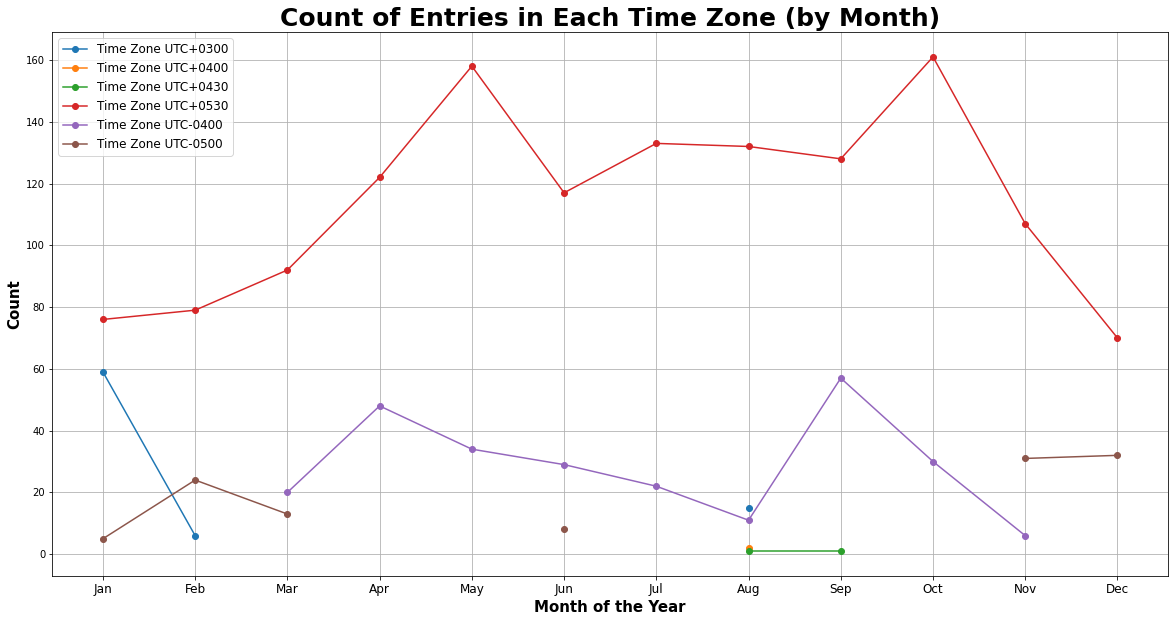

In [101]:
import calendar

# With 'create_time' column not in datetime format we convert 'create_time' to datetime format
sleep['create_time'] = pd.to_datetime(sleep['create_time'], format='%m/%d/%Y %H:%M')

# Count entries in each time zone by month
count_per_month = sleep.groupby([sleep['create_time'].dt.month, sleep['time_offset']]).size().unstack()

# Plotting count of entries in each time zone using a line plot with markers
plt.figure(figsize=(20, 10))

# Loop through each time zone
for time_offset in count_per_month.columns:
    plt.plot(count_per_month.index, count_per_month[time_offset], marker='o', label=f'Time Zone {time_offset}')

plt.title('Count of Entries in Each Time Zone (by Month)', fontsize=25, fontweight='bold')
plt.xlabel('Month of the Year', fontsize=15, fontweight='bold')
plt.ylabel("Count", fontsize=15, fontweight='bold')

# Map month numbers to month names
month_names = [calendar.month_abbr[i] for i in range(1, 13)]
plt.xticks(count_per_month.index, labels=month_names, fontsize=12)

plt.legend(fontsize=12)
plt.grid(True)

plt.show()


### Understanding if time zones play a role in sleep distribution

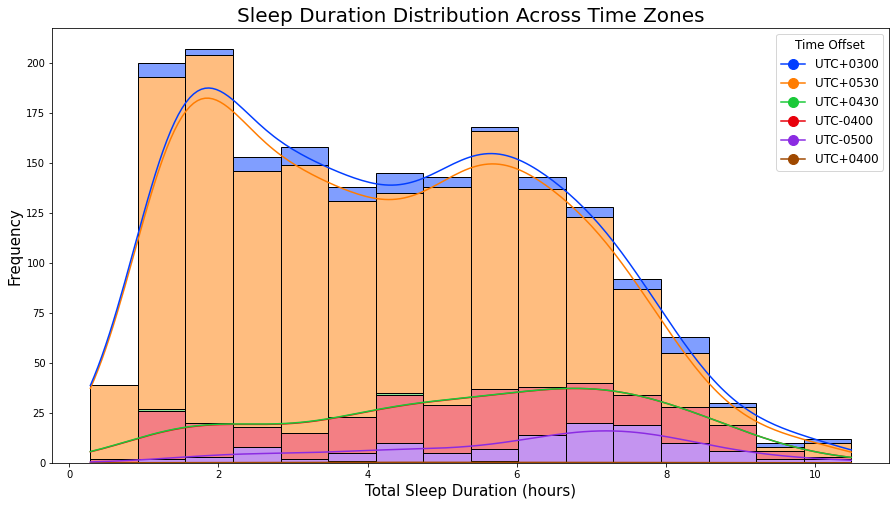

In [109]:
# Get unique 'time_offset' values from the dataset
unique_time_offsets = sleep['time_offset'].unique()

# Generate a brighter color palette for time_offset values
palette = sns.color_palette("bright", len(unique_time_offsets))

# Create a dictionary to map time_offset values to colors
time_offset_colors = dict(zip(unique_time_offsets, palette))

# Plot histograms for sleep duration across different time zones
plt.figure(figsize=(15, 8))
sns.histplot(data=sleep, x='total_sleep_hours', hue='time_offset', multiple='stack', palette=time_offset_colors, kde=True)
plt.title('Sleep Duration Distribution Across Time Zones', fontsize=20)
plt.xlabel('Total Sleep Duration (hours)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

# Create a custom legend based on the time_offset_colors dictionary
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=key, markersize=10) for key, color in time_offset_colors.items()]
plt.legend(handles=legend_elements, title='Time Offset', fontsize=12, title_fontsize=12)

plt.show()


### Plotting Average Sleep in each time-zone

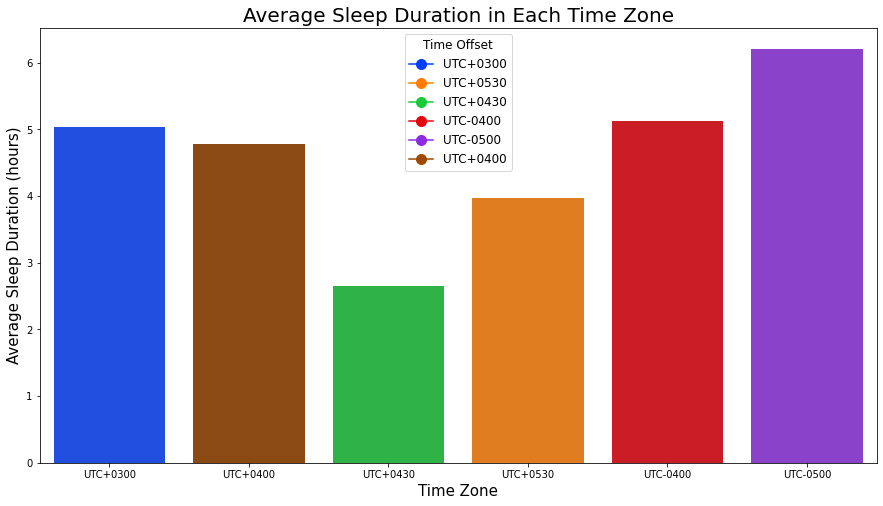

In [110]:
# Calculate average sleep duration per time zone
average_sleep_by_timezone = sleep.groupby('time_offset')['total_sleep_hours'].mean().reset_index()

# Get unique 'time_offset' values from the dataset
unique_time_offsets = sleep['time_offset'].unique()

# Generate a brighter color palette for time_offset values
palette = sns.color_palette("bright", len(unique_time_offsets))

# Create a dictionary to map time_offset values to colors
time_offset_colors = dict(zip(unique_time_offsets, palette))

# Plot average sleep duration in each time zone
plt.figure(figsize=(15, 8))
sns.barplot(x='time_offset', y='total_sleep_hours', data=average_sleep_by_timezone, palette=time_offset_colors)
plt.title('Average Sleep Duration in Each Time Zone', fontsize=20)
plt.xlabel('Time Zone', fontsize=15)
plt.ylabel('Average Sleep Duration (hours)', fontsize=15)

# Create a custom legend based on the time_offset_colors dictionary
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=key, markersize=10) for key, color in time_offset_colors.items()]
plt.legend(handles=legend_elements, title='Time Offset', fontsize=12, title_fontsize=12)

plt.show()


### Plotting Average sleep across weekdays to study if there is a notifiable difference in weekdays vs weekends

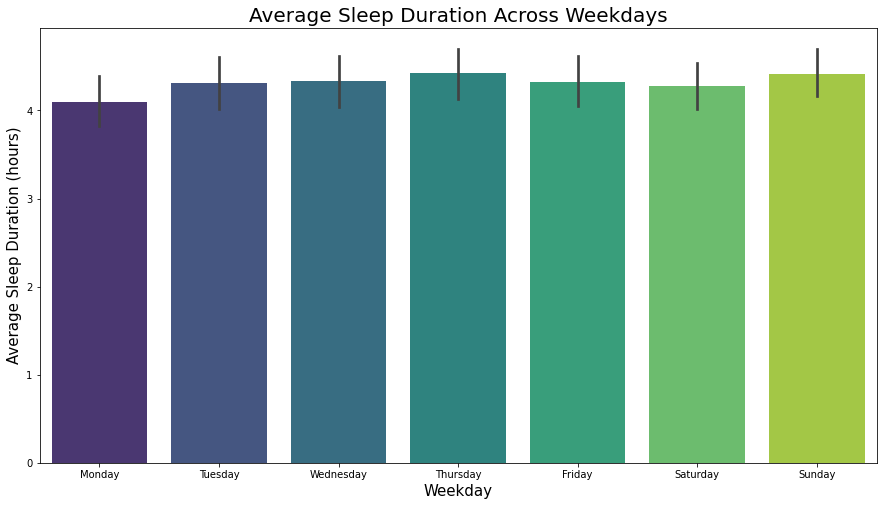

In [111]:
# Extract weekdays from the 'create_time' column
sleep['weekday'] = sleep['create_time'].dt.day_name()

# Plot bar plot for duration of sleep across weekdays
plt.figure(figsize=(15, 8))
sns.barplot(x='weekday', y='total_sleep_hours', data=sleep, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Sleep Duration Across Weekdays', fontsize=20)
plt.xlabel('Weekday', fontsize=15)
plt.ylabel('Average Sleep Duration (hours)', fontsize=15)

plt.show()
